In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [12]:
act_names = ["ActivityCode", "UserID", "WorkCode", "AssignmentID", "ProductID", "Quantity", "Timestamp", "LocationID"]

act_dtypes = {
    "ActivityCode": str,
    "UserID": int,
    "WorkCode": str,
    "AssignmentID": int,
    "ProductID": float,
    "Quantity": float,
    "Timestamp": str,
    "LocationID": float
}

loc_names = ["LocationID", "Aisle", "Bay", "Level", "Slot"]

loc_dtypes= {
    "LocationID": int,
    "Aisle": str,
    "Bay": str,
    "Level": str,
    "Slot": str
}

prod_names = ["ProductID", "ProductCode", "UnitOfMeasure", "Weight", "Cube", "Length", "Width", "Height"]

prod_dtypes = {
    "ProductID": int,
    "ProductCode": str,
    "UnitOfMeasure": str,
    "Weight": float,
    "Cube": float,
    "Length": float,
    "Width": float,
    "Height": float
}


rt_activity = pd.read_csv("~/Desktop/lucas/database_backups_csv/RT/RT_Activity.csv", header=None, names=act_names, dtype=act_dtypes)
rt_location = pd.read_csv("~/Desktop/lucas/database_backups_csv/RT/RT_Locations.csv", header=None, names=loc_names, dtype=loc_dtypes)
rt_products = pd.read_csv("~/Desktop/lucas/database_backups_csv/RT/RT_Products.csv", header=None, names=prod_names, dtype=prod_dtypes)
distance_rt = pd.read_csv("~/Desktop/lucas/distance_matrices/distance_matrix_RT.csv",
                          index_col="Unnamed: 0")
distance_lookup = distance_rt.stack().reset_index()
distance_lookup.columns = ["Prior_Location", "Location", "Distance"]

In [14]:
# Data Cleaning
rt_df = rt_activity.copy()
rt_df = rt_df.merge(rt_location, on="LocationID", how="left")
rt_df = rt_df.merge(rt_products, on="ProductID", how="left")


rt_df["Timestamp"] = pd.to_datetime(rt_df["Timestamp"])
rt_df["Hour"] = rt_df["Timestamp"].dt.hour


rt_df["Aisle"] = rt_df["Aisle"].astype(str).str.replace(r'\.0$', '', regex=True)
single_digits = rt_df["Aisle"].str.match(r'^\d$')
rt_df.loc[single_digits, "Aisle"] = rt_df.loc[single_digits, "Aisle"].str.zfill(2)
rt_df["Aisle"] = rt_df["Aisle"].replace('nan', None)


rt_df["Bay"] = rt_df["Bay"].astype(str).str.replace(r'\.0$', '', regex=True)
single_digits = rt_df["Bay"].str.match(r'^\d$')
rt_df.loc[single_digits, "Bay"] = rt_df.loc[single_digits, "Bay"].str.zfill(2)
rt_df["Bay"] = rt_df["Bay"].replace('nan', None)


rt_df = rt_df.sort_values(["UserID", "Timestamp"])
#rt_df["Hour"] = rt_df["Timestamp"].dt.floor("H")
rt_df["Pick_Time"] = (
    rt_df.groupby("UserID")["Timestamp"]
      .diff()
      .dt.total_seconds() / 3600
)
rt_df["Shift"] = (
    (rt_df["Pick_Time"] >= 3)
    .groupby(rt_df["UserID"])
    .cumsum() + 1
)
rt_df.loc[
    rt_df.groupby(["UserID", "Shift"]).cumcount() == 0,
    "Pick_Time"
] = np.nan
rt_df["Location"] = rt_df["Aisle"] + "|" + rt_df["Bay"] + "|||"


# 1. Ensure sorting is correct first
rt_df = rt_df.sort_values(["UserID", "Timestamp"])
# 2. Identify "Physical" locations (ignore AssignmentOpen)
# We create a temporary column that is Null when it's an AssignmentOpen
rt_df["Temp_Loc"] = rt_df["Location"]
rt_df.loc[rt_df["ActivityCode"] == "AssignmentOpen", "Temp_Loc"] = np.nan
# 3. Find the 'Last Valid Location' within each User/Shift group
# This "jumps over" the AssignmentOpen rows to find the most recent real location
rt_df["Last_Valid_Loc"] = (
    rt_df.groupby(["UserID", "Shift"])["Temp_Loc"]
    .ffill()
)
# 4. Prior_Location is the Last_Valid_Loc rt the PREVIOUS row
rt_df["Prior_Location"] = (
    rt_df.groupby(["UserID", "Shift"])["Last_Valid_Loc"]
    .shift(1)
)
# 5. Perform the Distance Lookup (Merge)
# Ensure your distance_lookup table columns are ["Prior_Location", "Location", "Distance"]
rt_df = rt_df.merge(distance_lookup, on=["Prior_Location", "Location"], how="left")
# 6. Apply Final NULL Rules
# Rule A: No Distance if Pick_Time is NaN (includes the first pick rt a shift)
rt_df.loc[rt_df["Pick_Time"].isna(), "Distance"] = np.nan
# Rule B: No Distance if the current row is AssignmentOpen
rt_df.loc[rt_df["ActivityCode"] == "AssignmentOpen", "Distance"] = np.nan
# 7. Cleanup temporary columns
rt_df.drop(columns=["Temp_Loc", "Last_Valid_Loc"], inplace=True)

In [61]:
rt_df.head(20)

,ActivityCode,UserID,WorkCode,AssignmentID,ProductID,Quantity,Timestamp,LocationID,Aisle,Bay,...,Cube,Length,Width,Height,Hour,Pick_Time,Shift,Location,Prior_Location,Distance
0,AssignmentOpen,77,11,4463449,NaN,NaN,2024-05-28 07:48:18.667,NaN,None,None,...,NaN,NaN,NaN,NaN,7,NaN,1,NaN,NaN,NaN
1,AssignmentOpen,77,11,4463449,NaN,NaN,2024-05-28 07:48:21.253,NaN,None,None,...,NaN,NaN,NaN,NaN,7,0.000718,1,NaN,NaN,NaN
2,AssignmentOpen,77,11,4463445,NaN,NaN,2024-05-28 07:48:21.263,NaN,None,None,...,NaN,NaN,NaN,NaN,7,0.000003,1,NaN,NaN,NaN
3,AssignmentOpen,77,11,4463449,NaN,NaN,2024-05-28 07:48:22.857,NaN,None,None,...,NaN,NaN,NaN,NaN,7,0.000443,1,NaN,NaN,NaN
4,AssignmentOpen,77,11,4463445,NaN,NaN,2024-05-28 07:48:22.870,NaN,None,None,...,NaN,NaN,NaN,NaN,7,0.000004,1,NaN,NaN,NaN
5,AssignmentOpen,77,11,4463443,NaN,NaN,2024-05-28 07:48:22.877,NaN,None,None,...,NaN,NaN,NaN,NaN,7,0.000002,1,NaN,NaN,NaN
6,AssignmentOpen,77,11,4463449,NaN,NaN,2024-05-28 07:48:24.380,NaN,None,None,...,NaN,NaN,NaN,NaN,7,0.000417,1,NaN,NaN,NaN
7,AssignmentOpen,77,11,4463445,NaN,NaN,2024-05-28 07:48:24.390,NaN,None,None,...,NaN,NaN,NaN,NaN,7,0.000003,1,NaN,NaN,NaN
8,AssignmentOpen,77,11,4463443,NaN,NaN,2024-05-28 07:48:24.390,NaN,None,None,...,NaN,NaN,NaN,NaN,7,0.000000,1,NaN,NaN,NaN
9,AssignmentOpen,77,11,4463447,NaN,NaN,2024-05-28 07:48:24.397,NaN,None,None,...,NaN,NaN,NaN,NaN,7,0.000002,1,NaN,NaN,NaN


In [62]:
distance_lookup

,Prior_Location,Location,Distance
0,403:116,403:116,0
1,403:116,403:120,27
2,403:116,403:130,54
3,403:116,403:134,81
4,403:116,403:144,108
...,...,...,...
17081684,200End,850Start,2986
17081685,200End,825Start,3178
17081686,200End,800End,2410
17081687,200End,850End,2314


/var/folders/73/5rwjffnx27jg1j84mffv_y5m0000gn/T/ipykernel_78068/2709708260.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pick_train["Aisle"] = pick_train["Aisle"].astype("Int64")
/var/folders/73/5rwjffnx27jg1j84mffv_y5m0000gn/T/ipykernel_78068/2709708260.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pick_train["Bay"] = pick_train["Bay"].astype("Int64")


Text(0.5, 1.0, 'Layout of Pick to Item Tasks (01, 02, 03, 04)')

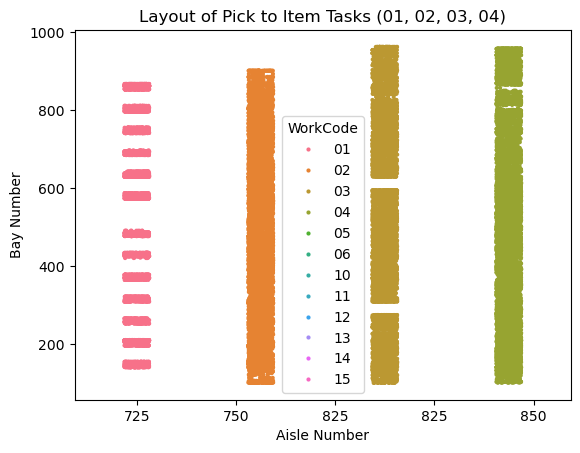

In [59]:
import matplotlib.ticker as ticker

pick_train = rt_df[rt_df["WorkCode"].isin(["01", "02", "03", "04"])]
pick_train["Aisle"] = pick_train["Aisle"].astype("Int64")
pick_train["Bay"] = pick_train["Bay"].astype("Int64")

fig, ax = plt.subplots()
sns.stripplot(data = pick_train, x = "Aisle", y = "Bay", hue = "WorkCode", size = 3, hue_order = ["01", "02", "03", "04", "05", "06", "10", "11", "12", "13", "14", "15"])
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
plt.xlabel("Aisle Number")
plt.ylabel("Bay Number")
plt.title("Layout of Pick to Item Tasks (01, 02, 03, 04)")

Text(0.5, 1.0, 'Warehouse Layout of RT Colored by WorkCode')

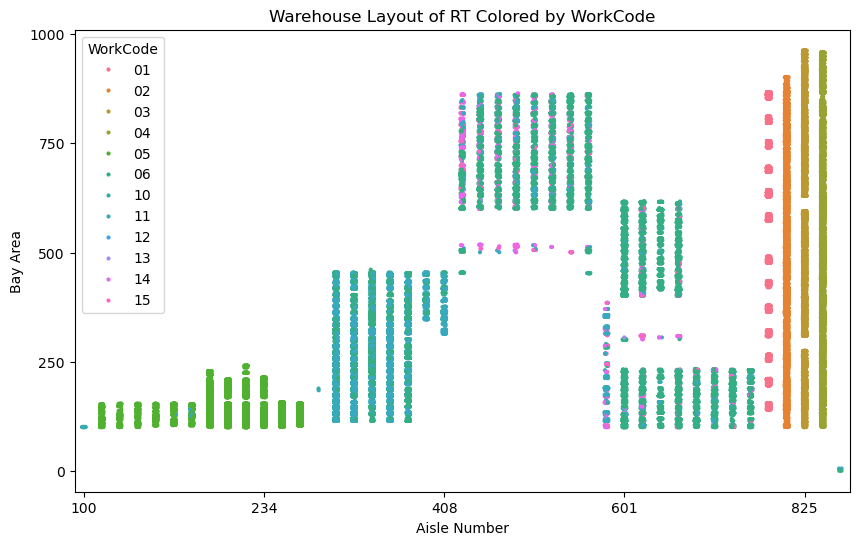

In [60]:
temp_df = rt_df.copy()
temp_df["Aisle"] = temp_df["Aisle"].astype("Int64")
temp_df["Bay"] = temp_df["Bay"].astype("Int64")

fig, ax = plt.subplots(figsize=(10, 6))
sns.stripplot(data = temp_df, x = "Aisle", y = "Bay", hue = "WorkCode", size = 3, hue_order = ["01", "02", "03", "04", "05", "06", "10", "11", "12", "13", "14", "15"])
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
plt.xlabel("Aisle Number")
plt.ylabel("Bay Area")
plt.title("Warehouse Layout of RT Colored by WorkCode")